In [1]:
# library
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

In [2]:
def linear_kernel(x1, x2):
    return x1.T @ x2

In [3]:
# main class
class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        if self._kernel == 'linear':
            self._k = linear_kernel
        self._c = c
        self.gamma=1
        self.degree=3
        self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**self.degree, 'rbf'   : lambda x,y: np.exp(-self.gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)), 'linear': lambda x,y: np.dot(x, y.T)}[kernel]
        self.value_C = 10000.0
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])
    def predict_score(self, x):
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b
        return u
    def predict(self, x):
        if self._kernel == 'linear':
            score = self.predict_score(x)
            if type(score) is np.ndarray:
                score[score < 0] = -1
                score[score >= 0] = 1
                return np.array([ 0 if x == -1 else 1 for x in score])
            else:
                return -1 if score < 0 else 1
        else:
            temp_cal = np.sum(self.kernel(x, self._data) * self._targets * self.vale_lambda_function, axis=1) + self.b
            final_ans = (np.sign(temp_cal) + 1) // 2
            return final_ans
        
    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0
        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]
        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2
        s = y1 * y2
        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)
        if L == H:
            return 0
        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)
        eta = k11 + k22 - 2 * k12
        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0
        a1 = alpha1 + s * (alpha2 - a2)
        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2
        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2
        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]
        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2
        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|
                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue
                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])
                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue
                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])
                        if error > max_error:
                            max_error = error
                            i1 = v
                if self.smo_step(i1, i2):
                    return 1
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
        return 0
    def fit(self, data, targets):
        self._data = data
        if self._kernel == 'linear':
            self._targets = targets
            self._init_params()
            n_changed = 0
            examine_all = True
            n_iter = 0
            while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
                n_changed = 0
                n_iter += 1
                if examine_all is True:
                    # loop over all training examples
                    for i in range(data.shape[0]):
                        n_changed += self.examine(i)
                else:
                    # loop over examples where alpha is not 0 & not value_C
                    f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                    for i, v in enumerate(f_idxs):
                        n_changed += self.examine(v)
                if examine_all is True:
                    examine_all = False
                elif n_changed == 0:
                    examine_all = True
        else:
            self._targets = targets * 2 - 1
            self.vale_lambda_function = np.zeros_like(self._targets, dtype=float)
            self.temp_K_val = self.kernel(self._data, self._data) * self._targets[:,np.newaxis] * self._targets
            for temp_loop in range(self._maxiter):
              for inner_loop_value in range(len(self.vale_lambda_function)):
                idxL = np.random.randint(0, len(self.vale_lambda_function))
                temp_value_q = self.temp_K_val[[[inner_loop_value, inner_loop_value], [idxL, idxL]], [[inner_loop_value, idxL], [inner_loop_value, idxL]]]
                temp_value_v = self.vale_lambda_function[[inner_loop_value, idxL]]
                temp_value_k = 1 - np.sum(self.vale_lambda_function * self.temp_K_val[[inner_loop_value, idxL]], axis=1)
                temp_value_u = np.array([-self._targets[idxL], self._targets[inner_loop_value]])
                t_max = np.dot(temp_value_k, temp_value_u) / (np.dot(np.dot(temp_value_q, temp_value_u), temp_value_u) + 1E-15)
                t = t_max
                t = (np.clip(temp_value_v + t*temp_value_u, 0, self.value_C) - temp_value_v)[1]/temp_value_u[1]
                temp_cal = (np.clip(temp_value_v + t*temp_value_u, 0, self.value_C) - temp_value_v)[0]/temp_value_u[0]
                self.vale_lambda_function[[inner_loop_value, idxL]] = temp_value_v + temp_value_u * temp_cal
            temp_value_index, = np.nonzero(self.vale_lambda_function > 1E-15)
            self.b = np.mean((1.0 - np.sum(self.temp_K_val[temp_value_index] * self.vale_lambda_function, axis=1)) * self._targets[temp_value_index])

In [4]:
# class for multi class
class Multi_SVM:
    def __init__(self, kernel):
        self.kernel = kernel
        self.collection_of_models = []
        self.final_predictions = []
    def fit(self, all_features, all_targets):
        for x in [0,1,2]:
            new_labels = [ 1 if y == x else 0 for y in all_targets ]
            features_train, features_test, label_train, label_test = train_test_split(all_features, np.array(new_labels), random_state=0, test_size= 0.1)
            temp_trained_dumping = svm(self.kernel)
            temp_trained_dumping.fit(features_train, label_train)
            predicted_labels = temp_trained_dumping.predict(features_test)
            self.collection_of_models.append([x,temp_trained_dumping,accuracy_score(label_test, predicted_labels)])
    def prediction(self, all_features):
        temp_list = [x[1].predict(all_features) for x in self.collection_of_models]
        self.final_predictions = [ y.index(1) if 1 in y else 0 for y in [[int(row[i]) for row in temp_list] for i in range(len(temp_list[0]))] ]
        return self.final_predictions   

In [5]:
# main driver function for main class
def driver_function(features_train, features_test, label_train, label_test, kernel_value):
    proposed_model = svm(kernel=kernel_value)
    proposed_model.fit(features_train, label_train)
    y_pred = proposed_model.predict(features_test)
    final_acc = accuracy_score(label_test, y_pred)
    print("Accuracy of proposed model ->",final_acc)
    plot_decision_regions(features_test, label_test, proposed_model)
    plt.title(kernel_value+" Kernel - Designed Class Prediction")
    plt.show()
    standard_model = SVC(kernel=kernel_value)
    standard_model.fit(features_train, label_train)
    y_pred = standard_model.predict(features_test)
    final_acc = accuracy_score(label_test, y_pred)
    print("Accuracy of standard model ->",final_acc)
    plot_decision_regions(features_test, label_test, standard_model)
    plt.title(kernel_value+" Kernel - Sklearn Model Prediction")
    plt.show()

In [6]:
# funtion to run multi class classifier
def Multi_class_Run(all_features, all_targets, kernel):
    our_trained_model = Multi_SVM(kernel)
    our_trained_model.fit(all_features, all_targets)
    label_pred = our_trained_model.prediction(all_features)
    final_acc = accuracy_score(all_targets, label_pred)
    print("Accuracy for proposed multi class model -"+ kernel+" Kernel->", final_acc)
    standard_SVC_model = SVC(kernel=kernel)
    standard_SVC_model.fit(all_features, all_targets)
    predicted_labels = standard_SVC_model.predict(all_features)
    final_acc = accuracy_score(all_targets, predicted_labels)
    print("Accuracy for standard SVC model from sklearn - "+ kernel+" Kernel->", final_acc)

In [7]:
# Getting data
all_features, all_label = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
features_train, features_test, label_train, label_test = train_test_split(all_features, all_label, stratify=all_label, test_size=0.1)

Accuracy of proposed model -> 0.32


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


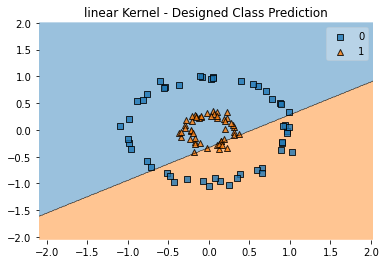

Accuracy of standard model -> 0.69


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


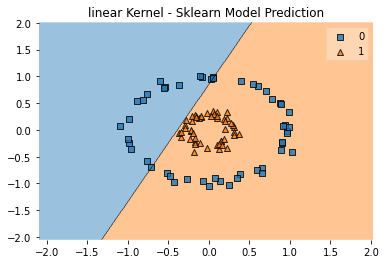

In [8]:
# Run 1
driver_function(features_train, features_test, label_train, label_test, 'linear')

Accuracy of proposed model -> 1.0


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


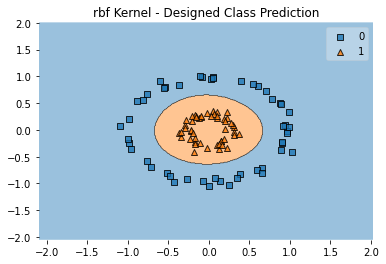

Accuracy of standard model -> 1.0


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


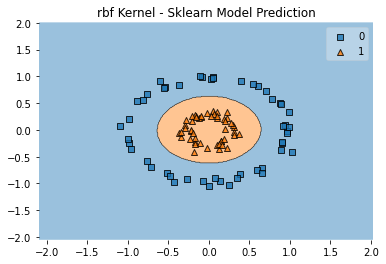

In [9]:
# Run 2
driver_function(features_train, features_test, label_train, label_test, 'rbf')

In [10]:
# importing second data
from sklearn import datasets
DataFrameIris = datasets.load_iris()
all_features, all_targets = DataFrameIris.data, DataFrameIris.target

In [11]:
# Run 1
Multi_class_Run(all_features, all_targets, 'linear')

Accuracy for proposed multi class model -linear Kernel-> 0.44
Accuracy for standard SVC model from sklearn - linear Kernel-> 0.9933333333333333


In [12]:
# Run 2
Multi_class_Run(all_features, all_targets, 'rbf')

Accuracy for proposed multi class model -rbf Kernel-> 1.0
Accuracy for standard SVC model from sklearn - rbf Kernel-> 0.9733333333333334
